# DATA QUALITY - Fruital census

# Library

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import udf
from typing import List, Dict, Optional, Callable, Union
import re
import string
import pyspark
import shapely
import pandas as pd
import geopandas as gpd
import nltk
import unidecode
from shapely.geometry import Polygon, Point
from geopandas import GeoDataFrame
import os
import fastparquet 
from nltk import ngrams
from ngram import NGram
from textdistance import damerau_levenshtein
from textdistance import jaro_winkler
from textdistance import sorensen_dice
from textdistance import jaccard
from textdistance import overlap
from textdistance import ratcliff_obershelp 


# Matching preparation functions

**function toools**

In [5]:
def function_vectorizer(input_function: Callable) -> Callable:
    """This function takes an input funcion that works with arbitrary input
    and vectorizes it so that the input function is applied to iterables
    (such as columns of a Spark DataFrame).
    The ouptut is always going to be pandas Series to ensure compliance
    with Spark DataFrames.
    
    Arguments:
        input_function {Callable} -- The input function.
    
    Returns:
        Callable -- The function vectorized (i.e. acting on each element of an
        iterable).
    """
 
    def vectorized_function(*args):
        return pd.Series([input_function(*tup) for tup in zip(*args)])
    
    return vectorized_function


**Test processing**

In [6]:
name_column_blacklist = ["cafe", "cf", "restaurant", "estaurant", "rest", "ag", "ste", "café", "snack", "hotel", "sarl", "rotisserie", "marrakech"]
name_column_regex_replace = {r"\'": "", r"\d{5}": "", r"\s+": " "}
address_column_blacklist = []
address_column_regex_replace = {r"\'": "", r"\s+": " ", "avenu ": "av ", "boulevard ": "bd "}

In [7]:
# Snowball stemmer was chosen in favor of Porter Stemmer which is a bit more aggressive and tends to remove too much from a word
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("stopwords")
 
# unidecode is the library needed for ASCII folding
from unidecode import unidecode
import string
# Compact Language Detector v3 is a very fast and performant algorithm by Google for language detection: more info here: https://pypi.org/project/pycld3/
import re
 
import pyspark.sql.functions as F
from typing import List, Dict, Optional, Callable
from langdetect import detect

[nltk_data] Downloading package punkt to C:\Users\Salif
[nltk_data]     SAWADOGO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Salif
[nltk_data]     SAWADOGO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
name_column_blacklist = ["cafe", "cf", "restaurant", "estaurant", "rest", "ag", "ste", "café", "snack", "hotel", "sarl", "rotisserie", "marrakech"]
name_column_regex_replace = {r"\'": "", r"\d{5}": "", r"\s+": " "}
address_column_blacklist = []
address_column_regex_replace = {r"\'": "", r"\s+": " ", "avenu ": "av ", "boulevard ": "bd "} 
def make_text_prep_func(row, word_blacklist, regex_replace, colonne) :
    try:
      STOPWORDS_EN = stopwords.words("english")
      STOPWORDS_FR = stopwords.words("french")
      STEMMER_EN = SnowballStemmer(language='english')
      STEMMER_FR = SnowballStemmer(language='french')
    except:
      nltk.download("punkt")
      nltk.download("stopwords")
      STOPWORDS_EN = stopwords.words("english")
      STOPWORDS_FR = stopwords.words("french")
      STEMMER_EN = SnowballStemmer(language='english')
      STEMMER_FR = SnowballStemmer(language='french')
    s=row[colonne]
 
    if s is None or s=="":
       return ""
#     STOPWORDS_EN = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
#     STOPWORDS_FR = ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 'auraient', 'avais', 'avait', 'avions', 'aviez', 'avaient', 'eut', 'eûmes', 'eûtes', 'eurent', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eusse', 'eusses', 'eût', 'eussions', 'eussiez', 'eussent']
    stop_words = STOPWORDS_EN + word_blacklist
    stemmer = STEMMER_EN
    s = s.lower()
     # check if the language is French
    s_lang = detect(s)
    if s_lang=="fr":
      stop_words = STOPWORDS_FR + word_blacklist
      stemmer = STEMMER_FR
 
    
    stop_words = STOPWORDS_FR + word_blacklist
    stemmer = STEMMER_FR
    s_clean = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    s_tokens = word_tokenize(s_clean)
    s_tokens_no_stop = [word for word in s_tokens if word not in stop_words]
    s_tokens_stemmed = [stemmer.stem(word) for word in s_tokens_no_stop]
    s_ascii = unidecode(" ".join(s_tokens_stemmed))
    
    for regex, replace in regex_replace.items():
      s_ascii = re.sub(regex, replace, s_ascii)
    return(s_ascii.strip())



In [9]:
address_column_blacklist

[]

**geospatial function**

In [10]:
def haversine_distance(row):

    longit_a=row.R_location_lon
    latit_a=row.R_location_lat
    longit_b=row.L_LONGITUDE
    latit_b=row.L_LATITUDE
    # Transform to radians
    longit_a, latit_a, longit_b, latit_b = map(np.radians, [longit_a,  latit_a, longit_b, latit_b])
    dist_longit = longit_b - longit_a
    dist_latit = latit_b - latit_a
    # Calculate area
    area = np.sin(dist_latit/2)**2 + np.cos(latit_a) * np.cos(latit_b) * np.sin(dist_longit/2)**2
    # Calculate the central angle
    central_angle = 2 * np.arcsin(np.sqrt(area))
    #   central_angle = 2 * np.arctan2(np.sqrt(area), np.sqrt(1-area))
    radius = 6371000
    # Calculate Distance
    distance = central_angle * radius
    return abs(round(distance, 2))
  
# haversine_distance_sdf = F.pandas_udf(function_vectorizer(haversine_distance),"double")

In [11]:
def sdf_to_gdf(sdf: pyspark.sql.dataframe.DataFrame,
               longitude: str = "longitude",
               latitude: str = "latitude",
               crs: str = "epsg:4326"
              ) -> GeoDataFrame:
  
  pdf = sdf.toPandas()
  gdf = gpd.GeoDataFrame(pdf, geometry=gpd.points_from_xy(pdf[longitude], pdf[latitude]), crs=crs)
  return(gdf)

**test similaity**

In [12]:
def compound_similarity(row,col1,col2):
    s1 = row[col1]
    s2 = row[col2]
    if s1 is None:
        s1 = ""
    if s2 is None:
        s2 = ""
    if s1 == "" and s2 == "":
        return 0.
    scores = [
                 damerau_levenshtein.normalized_similarity(s1, s2),
                 jaro_winkler.normalized_similarity(s1, s2),
                 sorensen_dice.normalized_similarity(s1, s2),
                 jaccard.normalized_similarity(s1, s2),
                 overlap.normalized_similarity(s1, s2),
                 ratcliff_obershelp.normalized_similarity(s1, s2),
                 NGram.compare(s1, s2, N=2)
             ]
    return np.mean(scores)

# Data :CMD Golden

**cmd dataset**

In [13]:
cmd = pd.read_excel("D:/data_quality/data/customer_invoice_tizi_ouzou.xlsx") [["Client", "LONGITUDE", "LATITUDE", "Nom", "Adresse"]]

In [14]:
cmd=cmd.rename(columns={"Client":"CUSTOMER_COD"})
cmd

,CUSTOMER_COD,LONGITUDE,LATITUDE,Nom,Adresse
0,72011,4.103267,36.607317,MANOUCHE AMAR,RUE TALA ATHMANE
1,72009,4.080755,36.620868,SADAOUI HAMID,RUE AMIROUCHE
2,72000,4.087680,36.617363,SARL TOUTE ELLA,RUE IGHIL HAMOU
3,71999,4.043520,36.695920,BOUZERD ABDENOUR,BENI DOUALA CENTRE
4,71998,4.178637,36.768272,DLIM SAID,RESIDENCE HADJILI BOUKHALFA
...,...,...,...,...,...
5572,29040,3.740273,36.612807,MDN/74° B.I.A (FOYER)TIZI-OUZOU,TIZI-OUZOU W-TIZI-OUZOU
5573,29012,4.317823,36.758588,MDN/12°G.I.R(FOYER) FREHA,FREHA
5574,29002,3.739110,36.623918,MDN/10°B.P.C(TAFSA),AZZAZGA W-TIZI-OUZOU
5575,28996,2.816000,36.472308,MDN/74 B.I.A (ORDINAIRE)TIZI-OUZOU,TIZI-OUZOU


**cmd golden Id**

In [15]:
cmd_golden_uri="C:/Users/Salif SAWADOGO/OneDrive - EQUATORIAL COCA-COLA BOTTLING COMPANY S.L/dynamic segmentation/matching/output/horeca_tz_customer_subset.csv"
cmd_golden_ids= pd.read_csv(cmd_golden_uri) [["CUSTOMER_COD"]]

In [16]:
cmd_golden_ids

,CUSTOMER_COD
0,56341
1,38014
2,38861
3,54921
4,37832
...,...
193,37785
194,38635
195,41385
196,54782


**merge datasets**

In [17]:
cmd_golden = cmd.merge(cmd_golden_ids, on="CUSTOMER_COD") 
cmd_golden

,CUSTOMER_COD,LONGITUDE,LATITUDE,Nom,Adresse
0,67250,3.842823,36.537640,FOUNES HAKIM,OUACIF CENTRE
1,65126,4.059238,36.702653,COFFEE TIME,BVD LES BOUZARD KRIM BELKACEM
2,65115,3.959820,36.723993,RABHI SAMIR,COMMUNE AIN ZAOUIA CENTRE
3,65113,4.366767,36.666388,SADJI YOUCEF,MAKOUDA CENTRE
4,65061,3.955950,36.734243,AMAR CHERGUI,RUE DES FRERES MAMMERI
...,...,...,...,...,...
193,37785,4.208080,36.678827,CHEBAH RABAH,YAKOURENE CENTRE
194,37777,4.206327,36.526737,AGOUAZI KAMEL,YAKOURENE CENTRE
195,37775,4.206720,36.528201,DARANI SOUFIANE,YAKOURENE CENTRE
196,37766,4.337410,36.748385,TIACHTINE RACHID,TAZAGHARTE AZAZGA


**CLEAN string for Analysis**

In [18]:
cmd_golden["ADRESSE_CLEAN"]=cmd_golden.apply(lambda p:make_text_prep_func(p, address_column_blacklist, address_column_regex_replace,"Adresse"),axis=1)

In [19]:
cmd_golden["NOM_CLEAN"]=cmd_golden.apply(lambda p:make_text_prep_func(p, name_column_blacklist, name_column_regex_replace,"Nom"),axis=1)

# Data :TripAdvisor

**Reading**

In [12]:
tripadvisor_data_uri ="D:/dynamic segmentation/data_acquisition/TripAdvisor/code/output/ta_combined_l3_Algeria_prepped.parquet"

In [13]:
ta=pd.read_parquet(tripadvisor_data_uri)
ta

,url,fetched_at,id,status,name,address,price_range,avg_rating,review_topics,review_counts_total,...,details_room_types_bridal_suite,details_room_types_city_view,details_room_types_family_rooms,details_room_types_landmark_view,details_room_types_mountain_view,details_room_types_nonsmoking_rooms,details_room_types_ocean_view,details_room_types_pool_view,details_room_types_smoking_rooms_available,details_room_types_suites
0,https://www.tripadvisor.ie/Restaurant_Review-g...,2021-05-30 13:23:30.706244,837192593f8b210781067e2993f51504,200,Paris Beach,None,None,4.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.tripadvisor.ie/Restaurant_Review-g...,2021-05-30 13:23:30.708237,abcb832f5e8b4ef330943755f2f9ba3f,200,Pecherie Almirez,None,None,3.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.tripadvisor.ie/Restaurant_Review-g...,2021-05-30 13:23:30.703252,5c8b6fa583a458f35771c4d36ccb5066,200,Pizza 447 Mostaganem,None,None,3.5,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.tripadvisor.ie/Restaurant_Review-g...,2021-05-30 13:23:30.707241,8a5bf443cdc6075b36ae2c1f33bed08b,200,algerie,None,None,3.5,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.tripadvisor.ie/Restaurant_Review-g...,2021-05-30 13:23:30.702255,4acda38c466becb0757fa1200db778b7,200,Bekhchis Mostaganem,None,None,4.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,https://www.tripadvisor.ie/Hotel_Review-g30316...,2021-05-30 14:02:43.325745,417ec475b0f97767f8e2378b5cc5e0ce,200,Hotel El Mansour,"07 Rue Ozanam, Oran Algeria",None,NaN,None,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1233,https://www.tripadvisor.ie/Hotel_Review-g30316...,2021-05-30 14:02:49.403960,2cb212d340732c1db8aa122aa43b7bd4,200,Hotel Plaza Oran,"Hai Ibn Rochd, Blv Des Falaises, Oran 31000 Al...",None,3.0,None,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,https://www.tripadvisor.ie/Hotel_Review-g30316...,2021-05-30 14:02:49.786304,2f9964a038ab10d18f08335920baf218,200,Hotel Jasmine Oran,"09 Rue Sidi Fredj, Oran 31000 Algeria",None,NaN,None,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1235,https://www.tripadvisor.ie/Hotel_Review-g30316...,2021-05-30 14:02:49.935024,29afe88b514b588f24e3925d29ab722a,200,L'Escale Hotel,"Avenue Chakib Areslane, Oran 31000 Algeria",None,NaN,None,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**clean  addresses and names**

In [22]:
ta["name_CLEAN"]=ta.apply(lambda p:make_text_prep_func(p, name_column_blacklist, name_column_regex_replace,"name"),axis=1)

In [23]:
ta["address_CLEAN"]=ta.apply(lambda p:make_text_prep_func(p, address_column_blacklist, address_column_regex_replace,'address'),axis=1)

## similarity analysis

**cross join TripAdvisor data and cmd golden**

In [86]:
def match_join(l_sdf,
               l_id,
               l_lon,
               l_lat,
               l_name,
               l_addr,
               r_sdf,
               r_id,
               r_lon,
               r_lat,
               r_name,
               r_addr,
               distance_threshold_m,
               minimal = True
              ):
  l_slice = l_sdf[[l_id, l_lon, l_lat, l_name, l_addr,"Nom", "Adresse"]]
  r_slice = r_sdf[[r_id, r_lon, r_lat, r_name, r_addr,"name", "address"]]
  l_slice.columns= "L_"+l_slice.columns
  r_slice.columns = "R_"+ r_slice.columns
  l_slice['key'] = 1
  r_slice['key'] = 1
  
# to obtain the cross join we will merge on 
# the key and drop it.
 
  inner_joined = l_slice.merge(r_slice, on ='key').drop("key", 1)
#  l_joined = l_slice.join(inner_joined, l_slice.columns)
  return(inner_joined)

In [87]:
matched = match_join(cmd_golden, "CUSTOMER_COD", "LONGITUDE", "LATITUDE", "NOM_CLEAN", "ADRESSE_CLEAN", ta, "id", "location_lon", "location_lat", "name_CLEAN", "address_CLEAN", 2000)

In [88]:
matched.nunique()

L_CUSTOMER_COD      198
L_LONGITUDE         198
L_LATITUDE          198
L_NOM_CLEAN         198
L_ADRESSE_CLEAN     166
L_Nom               198
L_Adresse           171
R_id               1237
R_location_lon     1007
R_location_lat      996
R_name_CLEAN       1151
R_address_CLEAN     411
R_name             1207
R_address           415
dtype: int64

**Compute distance between TripAdvisor outlets and cmd golden outlets**

In [89]:
matched["dist_m"]=matched.apply(lambda p:haversine_distance(p),axis=1)

In [90]:
matched.shape

(244926, 15)

<AxesSubplot:>

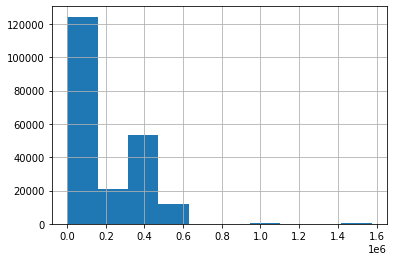

In [91]:
#matched=matched.loc[matched["dist_m"]<=2000]
matched["dist_m"].hist()

In [30]:
distance_threshold_m=2000

**distance similarity**

In [92]:
matched["dist_similarity"] =(distance_threshold_m - matched["dist_m"])/distance_threshold_m

In [32]:
matched


,L_CUSTOMER_COD,L_LONGITUDE,L_LATITUDE,L_NOM_CLEAN,L_ADRESSE_CLEAN,R_id,R_location_lon,R_location_lat,R_name_CLEAN,R_address_CLEAN,dist_m,dist_similarity
1407,65126,4.059238,36.702653,coffe tim,bvd bouzard krim belkacem,0b99d7f904615374d91a0aa795993572,4.052990,36.711100,bagdad,,1091.97,0.454015
1408,65126,4.059238,36.702653,coffe tim,bvd bouzard krim belkacem,a5d0577ea3cd1782a5b1a7b002669cad,4.048149,36.712734,ambassad,,1494.56,0.252720
1410,65126,4.059238,36.702653,coffe tim,bvd bouzard krim belkacem,5cbf6de57e02bd024f6e86933735ef41,4.041860,36.708270,senso,,1670.38,0.164810
1414,65126,4.059238,36.702653,coffe tim,bvd bouzard krim belkacem,8a3a182ce78dc4035699405ba689cdb7,4.042180,36.705530,tacos by paris,,1554.00,0.223000
1416,65126,4.059238,36.702653,coffe tim,bvd bouzard krim belkacem,6061ae77071b6fd4700fee7d84f05402,4.044240,36.713340,,,1788.76,0.105620
...,...,...,...,...,...,...,...,...,...,...,...,...
218648,38074,4.070410,36.709200,metahr karim,106 ru frer belhadj,23f1769012b0efd2234d521846056112,4.048780,36.713970,olympi,4 ru zidan amar tiz ouzou 15000 algeri,1999.72,0.000140
222243,38049,4.121183,36.892848,bourou amar,bvd amirouch to,beb9d80d80a6de8beaf212e4507730a9,4.133158,36.892204,iomnium palac,,1067.33,0.466335
223574,38041,4.104837,36.699468,tahraou youcef,ru aban remdan,71865d8a3f45da352fbb752420f24d08,4.109893,36.688050,rel vert,rout national no 30 a tiz ouzou algeri,1347.32,0.326340
226048,38021,4.108012,36.686363,medmoun said,ru aban remdan tiz ouzou,71865d8a3f45da352fbb752420f24d08,4.109893,36.688050,rel vert,rout national no 30 a tiz ouzou algeri,251.63,0.874185


**addresses and names similarities**

In [33]:
matched["name_similarity"]=matched.apply(lambda p:compound_similarity(p,"L_NOM_CLEAN","R_name_CLEAN"),axis=1)
matched["address_similarity"]=matched.apply(lambda p:compound_similarity(p,"L_ADRESSE_CLEAN","R_address_CLEAN"),axis=1)

**similarity overall**

In [39]:
matched["similarity"]= matched["name_similarity"]*0.15 +  matched["dist_similarity"]*0.8+matched["address_similarity"]*0.05

**Rank by Customer ID**

In [42]:
matched["rank"]=matched.groupby(by="L_CUSTOMER_COD")["similarity"].rank("dense", ascending=False)

In [43]:
(matched["rank"]<=15).value_counts()

True     644
False    117
Name: rank, dtype: int64

In [44]:
matched_filter=matched.loc[matched["rank"]<=15]

In [46]:
matched_filter.to_excel("C:/Users/Salif SAWADOGO/OneDrive - EQUATORIAL COCA-COLA BOTTLING COMPANY S.L/dynamic segmentation/matching/output/manual_match.xlsx")

In [51]:
matched.L_CUSTOMER_COD.nunique()

63

In [49]:
cmd_golden.CUSTOMER_COD.nunique()

198

In [17]:
#Marrakech city shape to filter for
tizi_ouzou = gpd.read_file(os.path.join("C:/Users/Salif SAWADOGO/OneDrive - EQUATORIAL COCA-COLA BOTTLING COMPANY S.L/dynamic segmentation/urbanicty/Tizi ouzou shapefile", "TZ.shp")) 

In [89]:
sub_set = gpd.sjoin(tizi_ouzou,temp, op="intersects")

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

<AxesSubplot:>

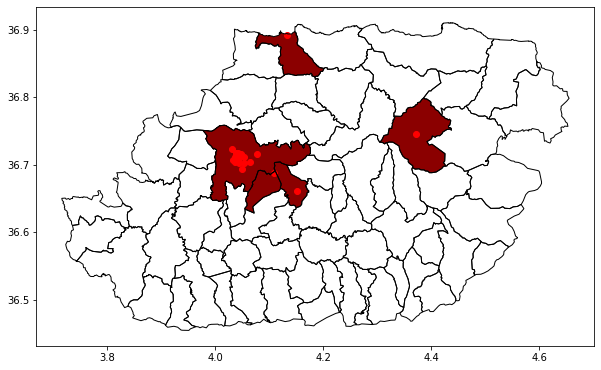

In [78]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10)) 
sub_set = gpd.sjoin(tizi_ouzou,ta_gdf, op="intersects")
sub_set.plot(ax=ax, color='darkred', lw=0.5)
tizi_ouzou.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
gpd.GeoDataFrame(sub_set, 
                 geometry=gpd.points_from_xy(sub_set["location_lon"],sub_set["location_lat"]), 
                 crs="epsg:4326").plot(ax=ax,marker="o",color="red")

In [69]:
#algeria=gpd.read_file("D:dynamic segmentation/algeria census/data/algeria_administrative_level_data/dza_admbnda_adm1_unhcr_20200120.shp")

data_fruital=algeria.set_index("ADM1_EN")

fruital=["Alger",'Tizi Ouzou','Boumerdes','Blida','Medea','Tipaza','Bouira',"Bordj Bou Arrer",'Ain-Defla','Djelfa','Ghardaia','Laghouat','Tamanrasset',"M'Sila",'Chlef','Ouargla']
data_fruital=data_fruital.loc[fruital]
data_fruital=data_fruital.reset_index()

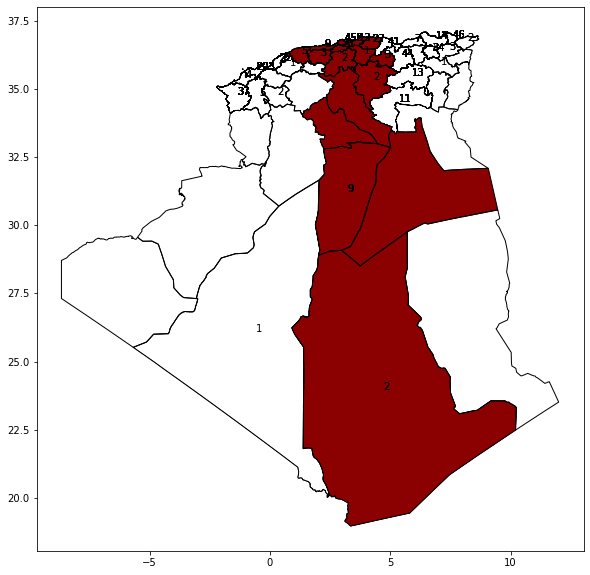

In [87]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10)) 
sub_set = gpd.sjoin(algeria,ta_gdf, op="intersects")
sub_set.plot(ax=ax, color='None', lw=0.5)
c=data_fruital.plot(column='ADM1_EN',
                ax=ax,color="darkred")
algeria.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) 
sub_set2=sub_set.merge(temp, how='inner')
#gpd.GeoDataFrame(sub_set, 
#                 geometry=gpd.points_from_xy(sub_set["location_lon"],sub_set["location_lat"]), 
#                 crs="epsg:4326").plot(ax=ax,marker="o",color="red",column="id")
for x, y, label in zip(sub_set2.geometry.centroid.x, sub_set2.geometry.centroid.y, sub_set2["count poi horeca"]):
    ax.annotate(label, xy=(x, y), xytext=(1, 1),textcoords="offset points")

In [88]:
temp=sub_set.groupby("ADM1_EN")['id'].count().\
    reset_index().\
    rename(columns={"id":"count poi horeca"}).\
    sort_values(by="count poi horeca",ascending=False)

,ADM1_EN,count poi horeca
3,Alger,458
22,Oran,203
4,Annaba,46
26,Setif,44
6,Bejaia,41
32,Tlemcen,37
13,Constantine,34
31,Tizi Ouzou,27
8,Blida,23
21,Mostaganem,22


In [90]:
sub_set

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_AR,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1AR,ADM1ALT2AR,...,details_room_types_bridal_suite,details_room_types_city_view,details_room_types_family_rooms,details_room_types_landmark_view,details_room_types_mountain_view,details_room_types_nonsmoking_rooms,details_room_types_ocean_view,details_room_types_pool_view,details_room_types_smoking_rooms_available,details_room_types_suites
0,34.573163,38.801661,Adrar,أدرا,DZ001,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.763140,0.455661,Ain-Defla,عين الدفلى,DZ002,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.763140,0.455661,Ain-Defla,عين الدفلى,DZ002,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.763140,0.455661,Ain-Defla,عين الدفلى,DZ002,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.198941,0.234566,Ain-Temouchent,عين تموشنت,DZ003,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,5.638095,0.885910,Tlemcen,تلمسان,DZ048,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,5.638095,0.885910,Tlemcen,تلمسان,DZ048,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47,5.638095,0.885910,Tlemcen,تلمسان,DZ048,None,None,None,None,None,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,5.638095,0.885910,Tlemcen,تلمسان,DZ048,None,None,None,None,None,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
ta_gdf = gpd.GeoDataFrame(ta, geometry=gpd.points_from_xy(ta["location_lon"], ta["location_lat"]), crs="epsg:4326")

In [222]:
sub_set.shape

(27, 484)

In [12]:
import pandas
data = pandas.read_csv("D:/data_quality/data/customer_invoice_tizi_ouzou.csv")

In [13]:
data['CHANNEL_CUSTOM'] = data['Détail Canal'].replace(['Frui-ALIMENTATION GE','Frui-SUPERETTE ET LI'], 'AG')
data['CHANNEL_CUSTOM'] = data['CHANNEL_CUSTOM'].replace(['Frui-CREMERIE','Frui-RESTAURANT / RO' ,'Frui-CAFE/CAFETERIA/','Frui-NIGHT CLUB','Frui-HOTELS',], 'HORECA')
data['CHANNEL_CUSTOM'] = data['CHANNEL_CUSTOM'].replace(['Frui-FAST FOOD / PIZ', 'Frui-PIZZERIA'], 'SNACK')
data['CHANNEL_CUSTOM'] = data['CHANNEL_CUSTOM'].replace(['Frui-DOUCHE','Frui-BUREAUX DE TABA','Frui-MOUKASSIRAT',"Frui-PATISSERIES",'Frui-FOYER','Frui-CREMERIE',"Frui-LOISIR",'Frui-SALLE DES FETES','Frui-MDN',"Frui-loisir","Frui-ADMINISTRATION","Frui-CYBER CAFE"], 'OTHER')

In [18]:
data=data.loc[~data["Classification client"].isin(["Platinum","Prestigieux"])]
data=data.loc[~data["CHANNEL_CUSTOM"].isin(["AG"])]


pandas.crosstab(data["Classification client"], data.CHANNEL_CUSTOM, margins=True)

CHANNEL_CUSTOM,HORECA,OTHER,SNACK,All
Classification client,,,,
Bronze,999,1,92,1092
Gold,15,0,21,36
Silver,447,1,135,583
Tin,21,518,759,1298
All,1482,520,1007,3009


## SIMILARITY ANALYSIS   : features importances